In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from astropy.io import fits

import hostphot
from hostphot.cutouts import download_images
from hostphot.coadd import coadd_images
from hostphot.image_masking import create_mask
import hostphot.local_photometry as lp
import hostphot.global_photometry as gp

print(hostphot.__version__)

2.2.0


## Download Cutouts

This example uses SN 2002fk (https://www.wis-tns.org/object/2002fk) as it has overlap of multiple surveys.

In [15]:
# depending on the science case, it might be better to 
# center the host galaxy in the image cutout 
name = '2002fk'  # https://www.wis-tns.org/object/2002fk
host_ra, host_dec = 50.527333, -15.400056  # host galaxy coordinates
surveys = ['PS1', 'GALEX', '2MASS','unWISEallwise', 'LegacySurvey']

for survey in surveys:
    download_images(name, host_ra, host_dec, survey=survey)

### Plotting the Images

In [3]:
def plot_image(data):
    m, s = np.nanmean(data), np.nanstd(data)

    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(data, interpolation='nearest',
               cmap='gray',
               vmin=m-s, vmax=m+s,
               origin='lower')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)    
    
    return ax

/tmp/ipykernel_12876/414575367.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(8, 8))


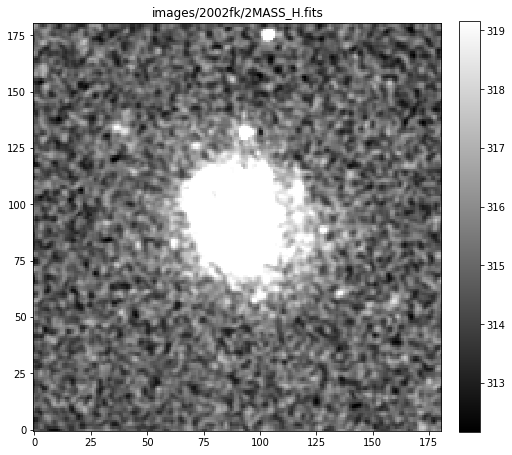

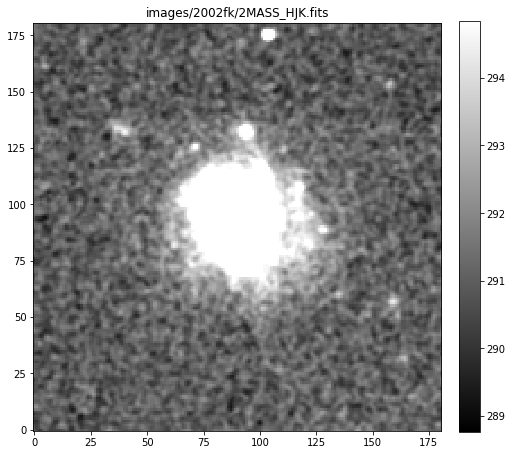

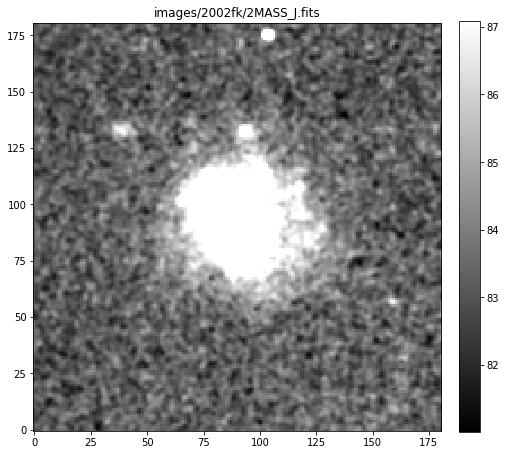

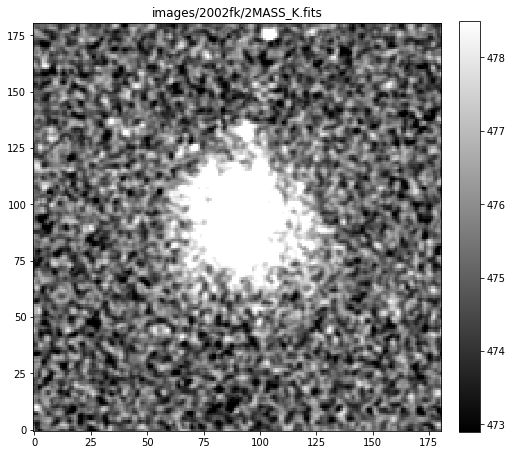

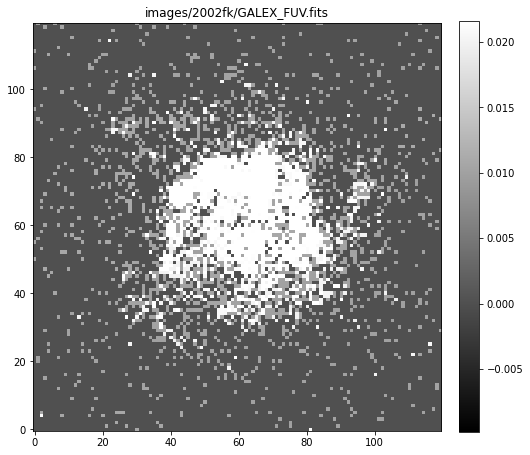

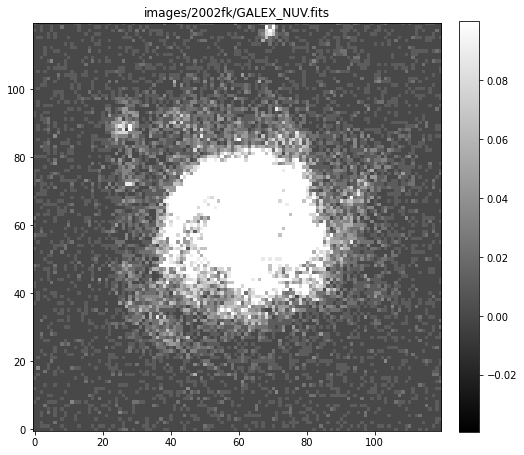

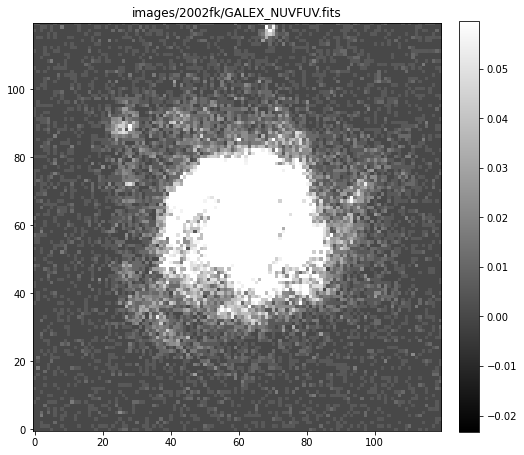

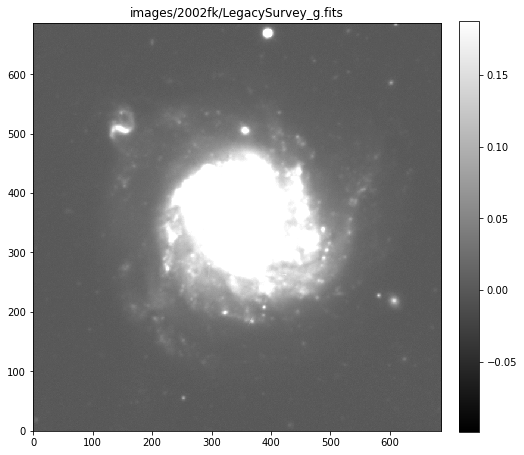

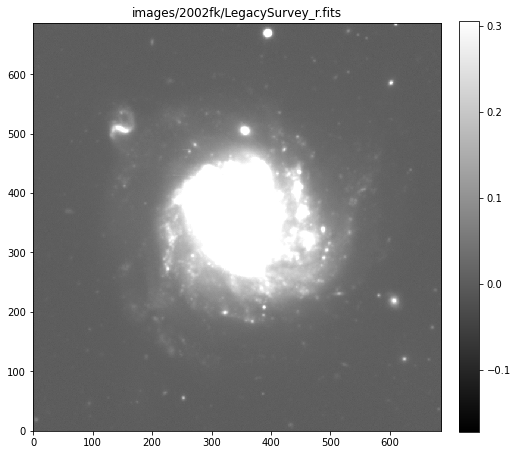

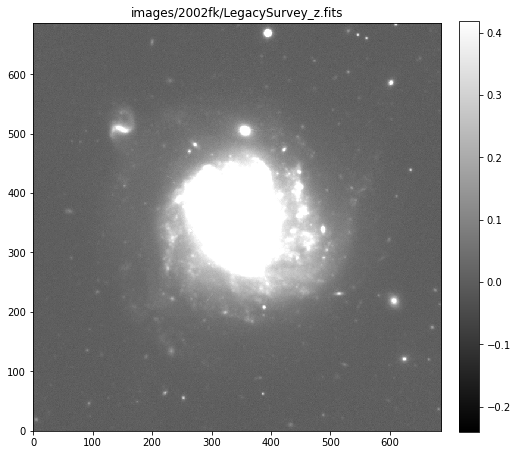

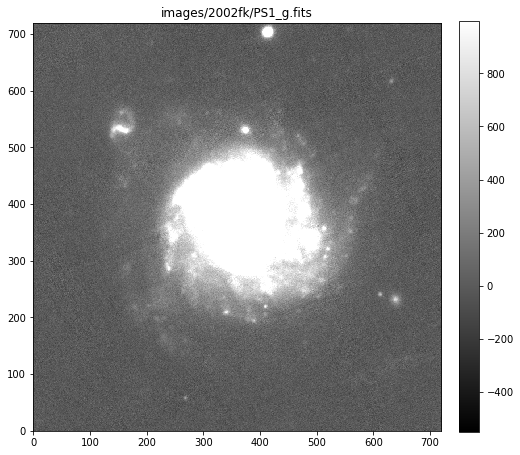

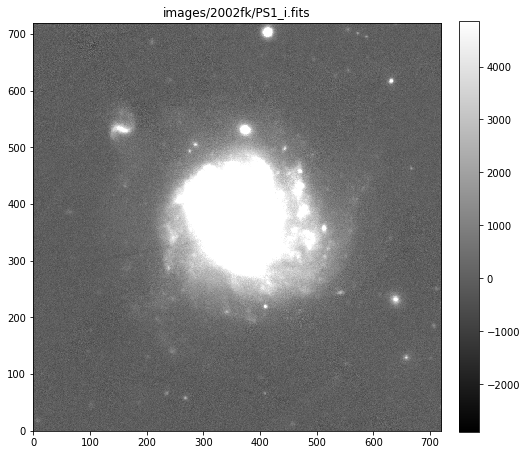

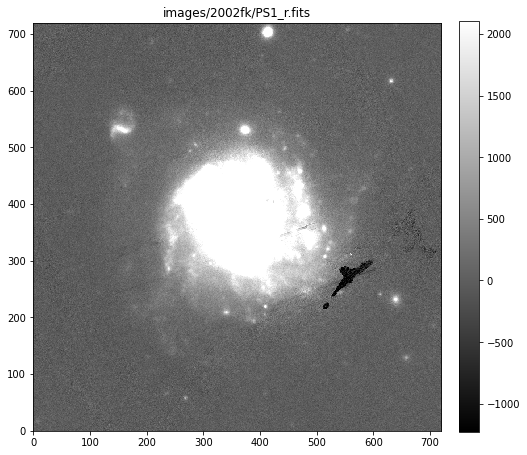

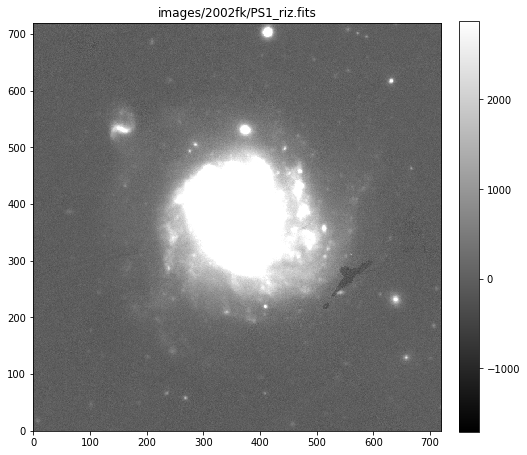

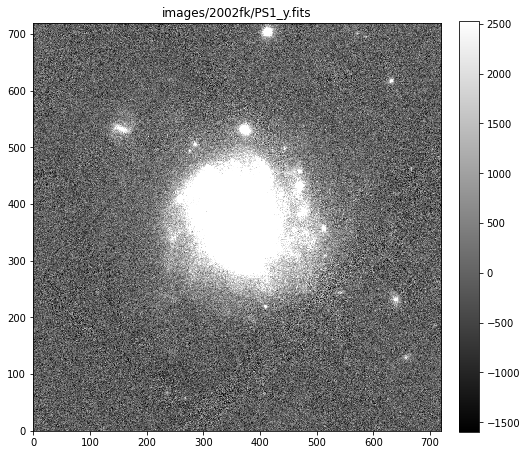

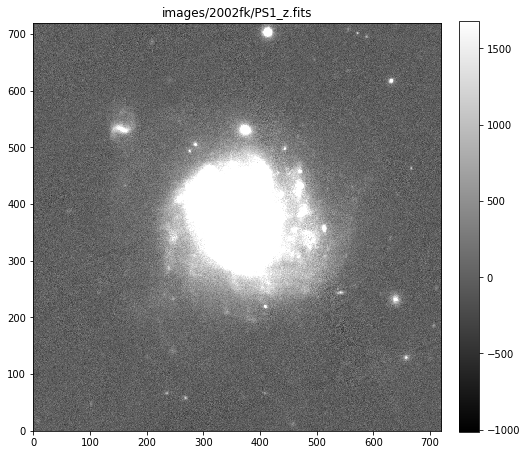

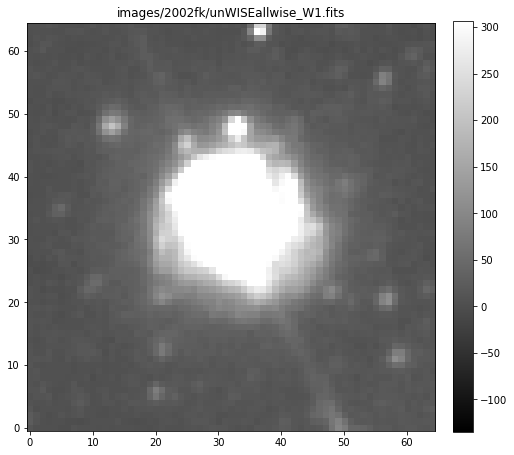

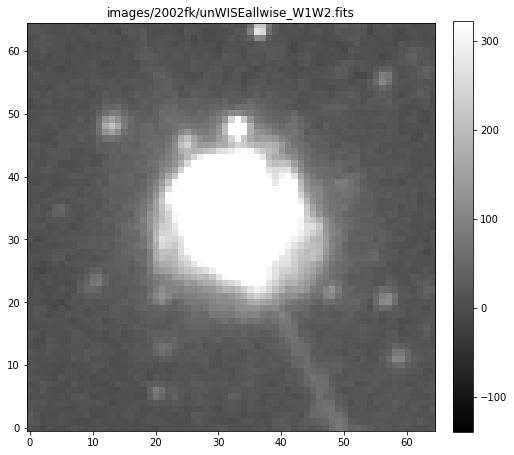

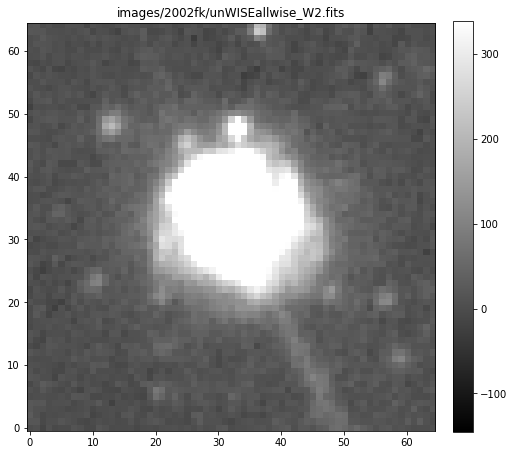

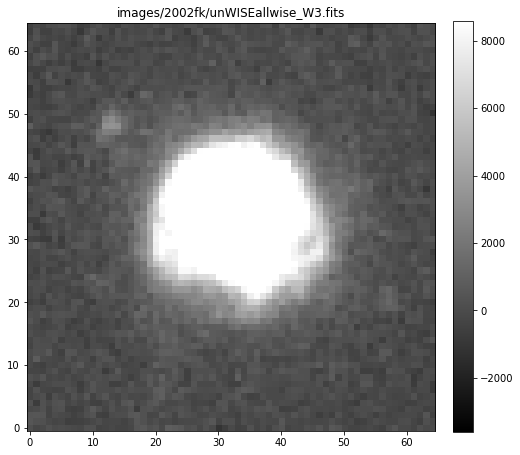

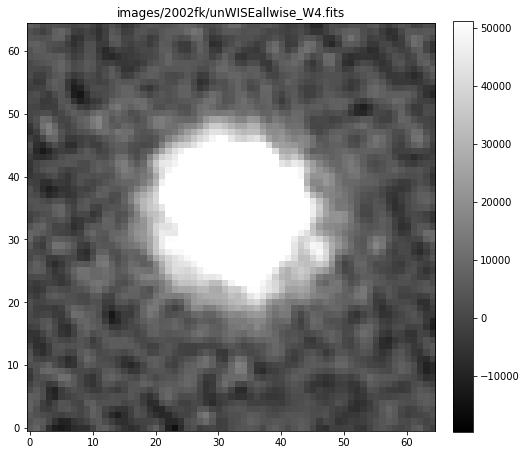

In [16]:
fits_files = glob.glob('images/*/*')
# remove images created as part of the processes bellow
fits_files = [file for file in fits_files if 'global' not in file]
fits_files = [file for file in fits_files if 'local' not in file]
fits_files = [file for file in fits_files if 'masked' not in file]
fits_files.sort()

for file in fits_files:
    hdu = fits.open(file)
    data = hdu[0].data
    ax = plot_image(data)
    ax.set_title(file)

## Image Pre-processing

### Coadding

We will create a coadd of multiple filters to get a "better quality" image.

If the filters are single letters (e.g. PS1 *grizy* filters), they can be given as a string. Otherwise, they should be given as a list (e.g. GALEX *NUV* and *FUV* filters).

In [17]:
survey = 'GALEX'

if survey=='PS1':
    coadd_filters = 'riz'
    filters = 'grizy'
if survey=='GALEX':
    coadd_filters = ['NUV', 'FUV']
    filters = ['NUV', 'FUV']
if survey=='2MASS':
    coadd_filters = 'HJK'
    filters = 'HJK'
if 'WISE' in survey:
    coadd_filters = ['W1', 'W2']
    filters = ['W1', 'W2', 'W3', 'W4']
if survey=='LegacySurvey':
    coadd_filters = 'riz'
    filters = 'grz'

coadd_images(name, filters=coadd_filters, survey=survey)

### Image Masking

By setting `crossmatch=True`, the detected objects with be crossmatched with a Gaia catalog. This can help to avoid masking galaxy structures.

The parameter `threshold` is used to set the threshold above which objects are detected. The optimal value will depend on things like survey and filter.

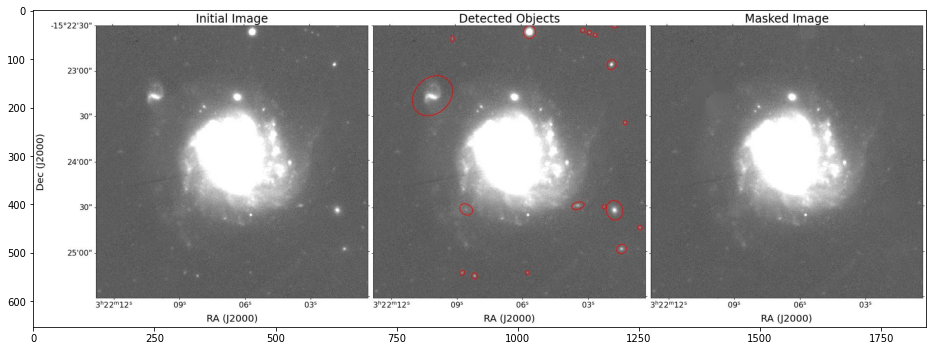

In [18]:
# one can extract the mask parameters from the coadd
# this also creates new fits files
survey = 'PS1'
coadd_filters = 'riz'
coadd_mask_params0 = create_mask(name, host_ra, host_dec,
                                filt=coadd_filters, survey=survey,
                                threshold=5,
                                extract_params=True)


for filt in 'grizy':
    create_mask(name, host_ra, host_dec, filt, survey=survey,
                common_params=coadd_mask_params0)
    
if isinstance(coadd_filters, list):
    coadd_file = os.path.join('images', name, f'masked_{survey}_{"".join(f for f in coadd_filters[1])}.jpg')
else:
    coadd_file = os.path.join('images', name, f'masked_{survey}_{coadd_filters[1]}.jpg')
img = mpimg.imread(coadd_file)

fig, ax = plt.subplots(figsize=(16, 6))
imgplot = ax.imshow(img)
plt.show()

In [7]:
# galaxy ellipse properties
coadd_mask_params0[0].dtype

dtype([('thresh', '<f8'), ('npix', '<i8'), ('tnpix', '<i8'), ('xmin', '<i8'), ('xmax', '<i8'), ('ymin', '<i8'), ('ymax', '<i8'), ('x', '<f8'), ('y', '<f8'), ('x2', '<f8'), ('y2', '<f8'), ('xy', '<f8'), ('errx2', '<f8'), ('erry2', '<f8'), ('errxy', '<f8'), ('a', '<f8'), ('b', '<f8'), ('theta', '<f8'), ('cxx', '<f8'), ('cyy', '<f8'), ('cxy', '<f8'), ('cflux', '<f8'), ('flux', '<f8'), ('cpeak', '<f8'), ('peak', '<f8'), ('xcpeak', '<i8'), ('ycpeak', '<i8'), ('xpeak', '<i8'), ('ypeak', '<i8'), ('flag', '<i8')])

In [20]:
gal_obj = coadd_mask_params0[0]
gal_obj['a']

array([63.96654892])

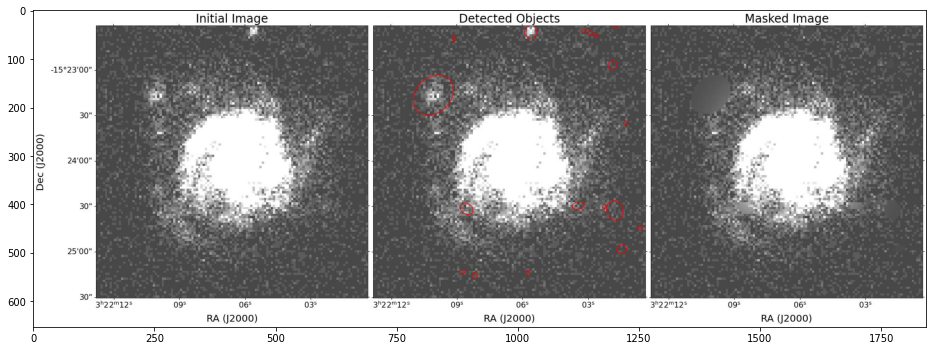

In [8]:
survey = 'GALEX'
coadd_filters = ['NUV', 'FUV']

# Use the mask created from the PS1 coadd image
for filt in coadd_filters:
    create_mask(name, host_ra, host_dec, filt, survey=survey,
                common_params=coadd_mask_params0)
    
if isinstance(coadd_filters, list):
    coadd_file = os.path.join('images', name, f'masked_{survey}_{"".join(f for f in coadd_filters[0])}.jpg')
else:
    coadd_file = os.path.join('images', name, f'masked_{survey}_{coadd_filters[0]}.jpg')
    
img = mpimg.imread(coadd_file)

fig, ax = plt.subplots(figsize=(16, 6))
imgplot = ax.imshow(img)
plt.show()

## Photometry

### Local

In [9]:
ap_radii = [3, 4]  # aperture radii in units of kpc
ra, dec =  50.52379, -15.40089 # coords of the SN
z = 0.0083  # redshift

results = lp.multi_band_phot(name, ra, dec, z,
                        survey=survey, ap_radii=ap_radii,
                        use_mask=True, correct_extinction=True,
                        save_plots=True)

In [10]:
results

{'name': '2002fk',
 'ra': 50.52379,
 'dec': -15.40089,
 'zspec': 0.0083,
 'survey': 'GALEX',
 'FUV3': 15.519077347398747,
 'FUV3_err': 0.06482004335851385,
 'FUV4': 14.872581055760481,
 'FUV4_err': 0.059786851473869675,
 'NUV3': 14.85114404511323,
 'NUV3_err': 0.032595241408517245,
 'NUV4': 14.257311914950929,
 'NUV4_err': 0.031105822421029012}

#### Plotting Image with Aperture

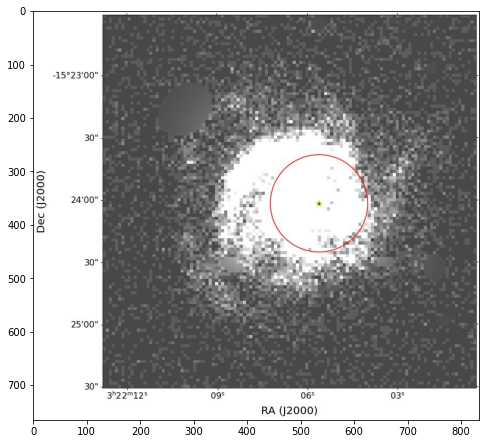

In [11]:
localphot_file = os.path.join('images', name, f'local_{survey}_{filters[0]}_{ap_radii[-1]}kpc.jpg')
img = mpimg.imread(localphot_file)

fig, ax = plt.subplots(figsize=(8, 8))
imgplot = ax.imshow(img)
plt.show()

### Global

In [12]:
results = gp.multi_band_phot(name, host_ra, host_dec,
                        survey=survey, ra=ra, dec=dec,
                        use_mask=True, correct_extinction=True, eps = 0.002,
                        common_aperture=True, coadd_filters=coadd_filters,
                        save_plots=True)

#### Plotting Image with Aperture

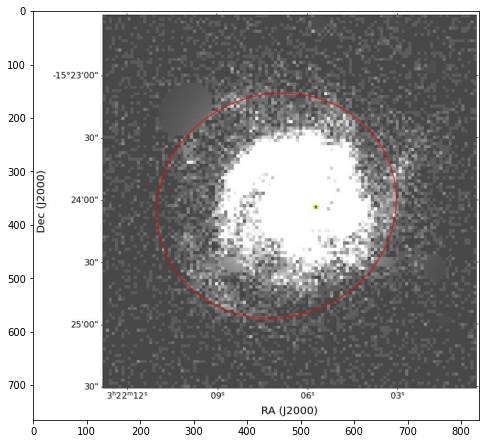

In [13]:
localphot_file = os.path.join('images', name, f'global_{survey}_{filters[0]}.jpg')
img = mpimg.imread(localphot_file)

fig, ax = plt.subplots(figsize=(8, 8))
imgplot = ax.imshow(img)
plt.show()

In [14]:
results

{'name': '2002fk',
 'host_ra': 50.527333,
 'host_dec': -15.400056,
 'survey': 'GALEX',
 'FUV': 13.866016886749334,
 'FUV_err': 0.9733316837895688,
 'NUV': 13.356508861659071,
 'NUV_err': 0.06292132260014721}

## Mag to Flux

All the nacessary information to convert from mag to flux is in https://hostphot.readthedocs.io/en/latest/further_information/config_file.html

For more information about the AB magnitude system, check: https://en.wikipedia.org/wiki/AB_magnitude

In [ ]:
# Vega to AB
m_vega = results['W1']
conv_factor = 2.699
m_AB = m_vega + conv_factor

# AB mag to flux (erg/s/cm^2/Hz)
flux_nu = 10**(-0.4*(m_AB + 48.60))  # in frequency units

# frequency to wavelength units: 
lam_eff = 34000*1e-10  # effective wavelength, although it should be the pivot wavelength
c =  3e18  # in angstroms/s
flux_lam = (c/lam_eff**2) * flux_nu

print(f'Flux (W1): {flux_lam:.2f} erg/s/cm²/angstroms')